# Setup

### Imports

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm.auto import tqdm as pbar
import torch
import torch.nn as nn
import pickle
from torch.autograd import Variable
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
from multisensory_playbook import DetectionTask, DetectionTask_versatile, ClassicalTask
import optuna
from scipy.optimize import fsolve
import re
import time

/home/jupyter-swathi/.conda/envs/cuda-env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Enable CUDA

In [2]:
%%time
# Check if CUDA is available
if torch.cuda.is_available():
    print("CUDA is available! GPU support is enabled.")
else:
    print("CUDA is not available. Please check your installation.")

# Set the default tensor type to CUDA tensors if CUDA is available
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')
    torch.set_default_device('cuda')

# Number of GPUs available
num_gpus = torch.cuda.device_count()
print(f"Number of GPUs available: {num_gpus}")

# Details of each GPU
for i in range(num_gpus):
    print(f"GPU {i}: {torch.cuda.get_device_name(i)}")
    print(f"  Memory Allocated: {torch.cuda.memory_allocated(i)} bytes")
    print(f"  Memory Cached: {torch.cuda.memory_reserved(i)} bytes")
    print(f"  Compute Capability: {torch.cuda.get_device_properties(i).major}.{torch.cuda.get_device_properties(i).minor}")


CUDA is available! GPU support is enabled.
Number of GPUs available: 1
GPU 0: NVIDIA RTX A6000
  Memory Allocated: 0 bytes
  Memory Cached: 0 bytes
  Compute Capability: 8.6
CPU times: user 10.6 ms, sys: 48.6 ms, total: 59.3 ms
Wall time: 94.3 ms


/home/jupyter-swathi/.conda/envs/cuda-env/lib/python3.12/site-packages/torch/__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at /opt/conda/conda-bld/pytorch_1712608847532/work/torch/csrc/tensor/python_tensor.cpp:431.)
  _C._set_default_tensor_type(t)


### Load benchmark dataset

## Hyperparameters

### Rerun this with new alg

In [ ]:
# Only FTA with 100k trials
path = './data/ideal_data_original'
infile = open(path, 'rb')
ideal_data_raw = pickle.load(infile)
infile.close()

ideal_data_original = {}
for key in ideal_data_raw:
    plt.plot(ideal_data_raw[key], marker='|', label = str(key))
    ideal_data_original[key] = np.max(ideal_data_raw[key])
plt.legend()
plt.grid()

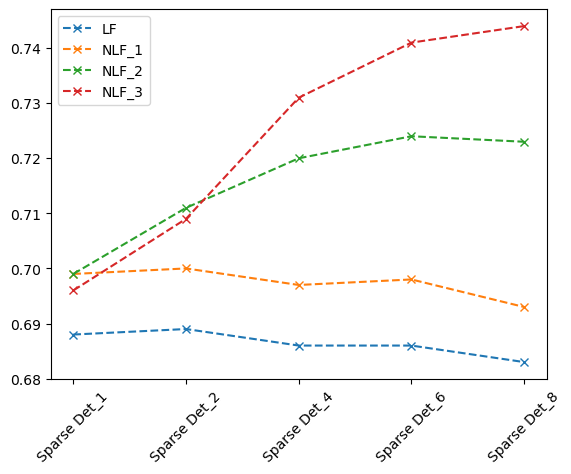

In [13]:
#df = pd.read_csv('./data/idea_data/ideal_data_sparse.csv')
# Set the 'Unnamed: 0' column as the index and rename it to 'task'
df = pd.read_csv('./data/idea_data/ideal_data_sparse:pc=0.15_buffer=1_re-gen=1_k8-correction=1.csv')
df.set_index('Unnamed: 0', inplace=True)
df.index.name = 'task'

plt.plot(df, ls='--', marker='x', label=df.columns)
plt.xticks(rotation=45)
plt.legend()

# RNN

In [5]:
32*300

9600

In [4]:
# Network 
nb_inputs = 4
nb_hidden = 150 # units in hidden layer
nb_layers = 1 # hidden layers
nb_outputs = 3
nb_epochs = 900
repeats = 1 # number of networks trained, original = 5
batch_size = 32 # Each batch has batch_size items
positive_weights = False
nb_trials = batch_size * 500 # original: 10000
nb_steps = 200 
learning_rate = 1e-6

def calc_pe(pe_precursor, k):
    """
    Calculate effective pe, given an input pe and on-length k
    """
    pe = 1 - ((1 - pe_precursor) ** k)
    return pe

def calc_precursor_pe(pe, k):
    """
    Calculate pe, given an effective pe and on-length k
    """
    precursor_pe= 1 - ((1-pe)**(1/k))
    return precursor_pe

def calc_pe(pe_precursor, k):
    """
    Calculate effective pe, given an input pe and on-length k
    """
    pe = 1 - ((1 - pe_precursor) ** k)
    return pe

def calc_precursor_pe(pe, k):
    """
    Calculate pe, given an effective pe and on-length k
    """
    precursor_pe= 1 - ((1-pe)**(1/k))
    return precursor_pe

def calculate_pg(ff, k, N=90, correction=1):
    """
    Use ff to calulate pg, given a k and N
    ff: desired filtered fraction of E 
    pg: probability of E(t)=1 in the base_e (generator)
    k : local on-time duration
    N : number time-steps
    """
    buffer = k
    #pg = (1-fsolve(lambda x: ff-(1-x**k)/(1-x**(N)), 0.9))[0] 
    if correction:
        ff = (1-fsolve(lambda x: ff-(1-x**k)/(1-x**(N+int(buffer)-1*(k-1))), 0.9))[0]

    return ff
 
# Tasks
p01_dense = 0.18
p11_dense = 0.58
p01_sparse = 0.03
p11_sparse = 0.53

# Detection task, old formulation
pe_dense = 0.3
pe_sparse = 0.04

# Detection task, new versatile formulation
time_dep = 1 # 1: there is time dependence

pc = 0.45
pm=1
task_labels = ['Sparse Det_8']
"""['Sparse Det_1',
 'Sparse Det_2',
 #'Sparse Det_3',
 'Sparse Det_4',
 #'Sparse Det_5',
 'Sparse Det_6',
 #'Sparse Det_7',
 'Sparse Det_8']
"""
tasks = [
    
    #ClassicalTask(s=0.1),  # classical task
    
    #DetectionTask(pm=pm, pe=pe_dense, pc=0.28, pn=1 / 3, pi=0.01),  # dense
    #DetectionTask(pm=pm, pe=pe_sparse, pc=0.95, pn=1 / 3, pi=0.01),  # sparse
    ##DetectionTask_versatile(pm=pm, pe=calc_precursor_pe(pe_dense, 1), pc=0.28, pn=1 / 3, pi=0.01, time_dep=time_dep, k=1), # dense
    ##DetectionTask_versatile(pm=pm, pe=calc_precursor_pe(pe_dense, 2), pc=0.28, pn=1 / 3, pi=0.01, time_dep=time_dep, k=2), # dense
    ##DetectionTask_versatile(pm=pm, pe=calc_precursor_pe(pe_dense, 3), pc=0.28, pn=1 / 3, pi=0.01, time_dep=time_dep, k=3), # dense

    ##DetectionTask_versatile(pm=pm, pe=calculate_pg(pe_sparse,  N=nb_steps+1-1, k=1), pc=pc, pn=1 / 3, pi=0.01, time_dep=time_dep, k=1), # sparse
    ##DetectionTask_versatile(pm=pm, pe=calculate_pg(pe_sparse,  N=nb_steps+2-1,k=2), pc=pc, pn=1 / 3, pi=0.01, time_dep=time_dep, k=2), # sparse  
    #DetectionTask_versatile(pm=pm, pe=calculate_pg(pe_sparse,  N=nb_steps+3-1,k=3), pc=pc, pn=1 / 3, pi=0.01, time_dep=time_dep, k=3), # sparse
    ##DetectionTask_versatile(pm=pm, pe=calculate_pg(pe_sparse,  N=nb_steps+4-1,k=4), pc=pc, pn=1 / 3, pi=0.01, time_dep=time_dep, k=4), # sparse
    #DetectionTask_versatile(pm=pm, pe=calculate_pg(pe_sparse,  N=nb_steps+5-1,k=5), pc=pc, pn=1 / 3, pi=0.01, time_dep=time_dep, k=5), # sparse 
    ##DetectionTask_versatile(pm=pm, pe=calculate_pg(pe_sparse,  N=nb_steps+6-1,k=6), pc=pc, pn=1 / 3, pi=0.01, time_dep=time_dep, k=6), # sparse 
    #DetectionTask_versatile(pm=pm, pe=calculate_pg(pe_sparse,  N=nb_steps+7-1,k=7), pc=pc, pn=1 / 3, pi=0.01, time_dep=time_dep, k=7), # sparse
    DetectionTask_versatile(pm=pm, pe=calculate_pg(pe_sparse,  N=nb_steps+8-1,k=8), pc=pc, pn=1 / 3, pi=0.01, time_dep=time_dep, k=8) # sparse
    
]

"""
task_labels = []
k_lim = 9
for kk in range(1,k_lim):
    task_labels.append(f"Sparse Det_{kk}")
"""
# Activation functions
unisensory_activation = lambda x: x * (x > 0)  # relu: return x if x>0, return 0 if x!>0


### Sparsity values

In [4]:
# Sparsity values
sparsity = {}
#sparsity['Dense detection'] = pe_dense
#sparsity['Sparse detection'] = pe_sparse
for k in range(1,k_lim):
    #sparsity[f'Dense Det_{k}'] = calc_pe(calc_precursor_pe(pe_dense, k), k)
    sparsity[f'Sparse Det_{k}'] = calc_pe(calc_precursor_pe(pe_sparse, k), k)

df_sparsity = pd.DataFrame(list(sparsity.values()), index=sparsity.keys(), columns=['Sparsity'])

df_sparsity

NameError: name 'k_lim' is not defined

In [ ]:
task_labels

## Functions

### Input layer

In [5]:
def build_input_layer(A, V):
    input_layer = [[] for _ in range(len(A))] # A is a batch 
    for trial in range(len(A)):
        audio_left = unisensory_activation(-A[trial])
        audio_right = unisensory_activation(A[trial])

        video_left = unisensory_activation(-V[trial])
        video_right = unisensory_activation(V[trial])

        input_layer[trial] = torch.from_numpy(
            1 * np.vstack([audio_left, audio_right, video_left, video_right])
        )  # input units x time
    stacked = torch.stack(input_layer, dim=0).permute(2, 0, 1) # timsteps x batchsize x inputdim
    stacked = stacked.to(torch.float32)
    return stacked


### Batch generator

In [6]:
def batch_generator_rnn(A, V, y_data, batch_size):
    # A, V are in shape [batch_size, seq_length, features]
    # Convert A and V from numpy array to tensors in order to use CUDA
    A_tensor = torch.from_numpy(A).cuda()  # Convert NumPy array to PyTorch tensor
    V_tensor = torch.from_numpy(V).cuda()  # Convert NumPy array to PyTorch tensor
    
    # Shuffle
    perm = torch.randperm(A_tensor.shape[0]).cuda()
    A_shuffled = A_tensor[perm]
    V_shuffled = V_tensor[perm]
    y_shuffled = y_data[perm]

    # Batches
    n_batches = A_tensor.shape[0] // batch_size

    for i in range(n_batches):
        # Extract batches for A, V, and y_data
        A_batch = A_shuffled[i * batch_size : (i + 1) * batch_size]
        V_batch = V_shuffled[i * batch_size : (i + 1) * batch_size]
        y_batch = y_shuffled[i * batch_size : (i + 1) * batch_size]

        # Check if there is only one class in the batch. If yes, skip this batch.
        """
        if len(torch.unique(y_batch)) == 1:
            print(f"batch {i+1} skipped: singular class in label data, y")
            continue
        """
        A_batch = A_batch.cpu().numpy()
        V_batch = V_batch.cpu().numpy()
        
        #print('y from batchmaker', y_batch.shape)
        yield A_batch, V_batch, y_batch


### Train function

In [7]:
# initialise V randomly (pweights for prev hidden layer)
def train_rnn(
    model,
    A,
    V,
    y_data,
    batch_size,
    optimizer,
    criterion,
    nb_epochs=10,
    lr=0.001,
    ):
    
    loss_hist = []
    for epoch in range(nb_epochs):
        batch_loss = []
           
        for A_batch, V_batch, y_batch in batch_generator_rnn(A, V, y_data, batch_size):
                 
            # Clear gradients w.r.t. parameters
            optimizer.zero_grad()
            input_layer = build_input_layer(A_batch, V_batch) # x is 25x4x90 with  (batchsize x inputdim x timestep)         
               
            outputs = model(input_layer)
            # Compute loss
            loss = criterion(outputs, y_batch)
            batch_loss.append(loss.item())

            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        
        if (epoch + 1) % 10 == 0:
            print(f'Epoch [{epoch+1}/{nb_epochs}], Loss: {loss.item():.4f}')


        loss_hist.append(np.mean(batch_loss))
    
    return loss_hist

## Run

### Test setup

In [8]:
task_labels = [
 
 'Sparse Det_8']

### Run without optimisation

In [7]:
# For RNN
task_labels = [#'Classical', 
 'Sparse Det_1',
 'Sparse Det_2',
 #'Sparse Det_3',
 'Sparse Det_4',
 #'Sparse Det_5',
 'Sparse Det_6',
# 'Sparse Det_7',
 'Sparse Det_8']

In [8]:
# Train networks
task_loss = []
task_loss_std = []
task_test_acc = []
k_list = [1,2,4,6,8]
for t, task in enumerate(pbar(tasks[:])):
    k = k_list[t]
    # Generate data
    print("k: ", k,task_labels[t])

    full_trials_train = task.generate_trials(nb_trials, nb_steps+k-1)
    full_trials_test = task.generate_trials(nb_trials, nb_steps+k-1)

    print('Train-Test generated') # logging
    
    # Generate labels
    y_train, A_train, V_train = torch.tensor(full_trials_train.M + 1), full_trials_train.A, full_trials_train.V
    y_test, A_test, V_test = torch.tensor(full_trials_test.M + 1), full_trials_test.A, full_trials_test.V

    repeat_loss = []
    for c in range(repeats):
        
        # Create a model instance
        rnn_layer = nn.RNN(input_size=nb_inputs, hidden_size=nb_hidden, nonlinearity='relu', batch_first=False)
        
        linear_layer = nn.Linear(nb_hidden, nb_outputs)
               
        def model(input_data): # require these inouts: , rnn_layer, linear_layer
            input_data = input_data.cuda()
            batchsize = input_data.shape[1]
            h0 = torch.zeros((1, batchsize, nb_hidden), dtype=torch.float32).cuda()
            out, h1 = rnn_layer(input_data, h0)
            lin_out = linear_layer(out)
            sum_out = lin_out.sum(axis=0).cuda()
            return sum_out
                                  
        
        optimizer = torch.optim.Adam(list(rnn_layer.parameters()) + list(linear_layer.parameters()), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss in PyTorch internally applies a LogSoftmax layer to its inputs before computing the negative log likelihood loss. 
    
        epoch_loss = train_rnn( # loss from each epoch
                model,
            A_train,
            V_train,
            y_train,
            batch_size,
            optimizer=optimizer,
            criterion=criterion,
            nb_epochs=nb_epochs,
            lr=learning_rate)
        repeat_loss.append(epoch_loss)
    repeat_loss_mean = np.mean(repeat_loss, axis = 0)   
    repeat_loss_std = np.std(repeat_loss, axis = 0)
    task_loss.append(repeat_loss_mean)
    task_loss_std.append(repeat_loss_std)
    
    with torch.no_grad():
        input_layer = build_input_layer(A_test, V_test)
        y_pred = model(input_layer).cpu().numpy()
        y_pred_argmax = np.argmax(y_pred, axis=1)
        test_acc = (np.mean(y_pred_argmax == y_test.cpu().numpy()))*100
        task_test_acc.append(test_acc)
    print(task_test_acc)
    #task_test_acc *= 100

    # Clear memory after each task
    del full_trials_train, full_trials_test, y_train, A_train, V_train, y_test, A_test, V_test, input_layer, y_pred, y_pred_argmax
    torch.cuda.empty_cache()
            


  0%|          | 0/5 [00:00<?, ?it/s]

k:  1 Sparse Det_1
Train-Test generated
Epoch [10/900], Loss: 0.6878
Epoch [20/900], Loss: 0.6533
Epoch [30/900], Loss: 0.6593
Epoch [40/900], Loss: 0.6356
Epoch [50/900], Loss: 0.6466
Epoch [60/900], Loss: 0.6212
Epoch [70/900], Loss: 0.5260
Epoch [80/900], Loss: 0.5908
Epoch [90/900], Loss: 0.5526
Epoch [100/900], Loss: 0.4609
Epoch [110/900], Loss: 0.5369
Epoch [120/900], Loss: 0.5599
Epoch [130/900], Loss: 0.4727
Epoch [140/900], Loss: 0.4317
Epoch [150/900], Loss: 0.5857
Epoch [160/900], Loss: 0.4710
Epoch [170/900], Loss: 0.6891
Epoch [180/900], Loss: 0.5264
Epoch [190/900], Loss: 0.5476
Epoch [200/900], Loss: 0.6011
Epoch [210/900], Loss: 0.6379
Epoch [220/900], Loss: 0.4924
Epoch [230/900], Loss: 0.6635
Epoch [240/900], Loss: 0.5791
Epoch [250/900], Loss: 0.5989
Epoch [260/900], Loss: 0.5407
Epoch [270/900], Loss: 0.5037
Epoch [280/900], Loss: 0.4859
Epoch [290/900], Loss: 0.5215
Epoch [300/900], Loss: 0.3768
Epoch [310/900], Loss: 0.4933
Epoch [320/900], Loss: 0.4286
Epoch [33

 20%|██        | 1/5 [35:33<2:22:14, 2133.74s/it]

[73.30624999999999]
k:  2 Sparse Det_2
Train-Test generated
Epoch [10/900], Loss: 0.6507
Epoch [20/900], Loss: 0.6248
Epoch [30/900], Loss: 0.6133
Epoch [40/900], Loss: 0.5972
Epoch [50/900], Loss: 0.5935
Epoch [60/900], Loss: 0.5235
Epoch [70/900], Loss: 0.4819
Epoch [80/900], Loss: 0.5425
Epoch [90/900], Loss: 0.5353
Epoch [100/900], Loss: 0.5210
Epoch [110/900], Loss: 0.5111
Epoch [120/900], Loss: 0.5140
Epoch [130/900], Loss: 0.5993
Epoch [140/900], Loss: 0.5728
Epoch [150/900], Loss: 0.7099
Epoch [160/900], Loss: 0.5628
Epoch [170/900], Loss: 0.5458
Epoch [180/900], Loss: 0.5129
Epoch [190/900], Loss: 0.5741
Epoch [200/900], Loss: 0.5073
Epoch [210/900], Loss: 0.5237
Epoch [220/900], Loss: 0.5622
Epoch [230/900], Loss: 0.4558
Epoch [240/900], Loss: 0.4486
Epoch [250/900], Loss: 0.5495
Epoch [260/900], Loss: 0.4324
Epoch [270/900], Loss: 0.5060
Epoch [280/900], Loss: 0.5552
Epoch [290/900], Loss: 0.6234
Epoch [300/900], Loss: 0.5693
Epoch [310/900], Loss: 0.5170
Epoch [320/900], Lo

 40%|████      | 2/5 [1:11:41<1:47:40, 2153.60s/it]

[73.30624999999999, 73.0125]
k:  4 Sparse Det_4
Train-Test generated
Epoch [10/900], Loss: 0.6637
Epoch [20/900], Loss: 0.6580
Epoch [30/900], Loss: 0.5896
Epoch [40/900], Loss: 0.5167
Epoch [50/900], Loss: 0.6716
Epoch [60/900], Loss: 0.5501
Epoch [70/900], Loss: 0.5805
Epoch [80/900], Loss: 0.5093
Epoch [90/900], Loss: 0.6144
Epoch [100/900], Loss: 0.4410
Epoch [110/900], Loss: 0.6183
Epoch [120/900], Loss: 0.4367
Epoch [130/900], Loss: 0.5147
Epoch [140/900], Loss: 0.5966
Epoch [150/900], Loss: 0.5052
Epoch [160/900], Loss: 0.3717
Epoch [170/900], Loss: 0.6247
Epoch [180/900], Loss: 0.5553
Epoch [190/900], Loss: 0.3664
Epoch [200/900], Loss: 0.5509
Epoch [210/900], Loss: 0.5234
Epoch [220/900], Loss: 0.5242
Epoch [230/900], Loss: 0.5062
Epoch [240/900], Loss: 0.5493
Epoch [250/900], Loss: 0.5398
Epoch [260/900], Loss: 0.4902
Epoch [270/900], Loss: 0.4545
Epoch [280/900], Loss: 0.7515
Epoch [290/900], Loss: 0.5282
Epoch [300/900], Loss: 0.6226
Epoch [310/900], Loss: 0.7490
Epoch [320

 60%|██████    | 3/5 [1:47:20<1:11:34, 2147.06s/it]

[73.30624999999999, 73.0125, 74.65625]
k:  6 Sparse Det_6
Train-Test generated
Epoch [10/900], Loss: 0.6129
Epoch [20/900], Loss: 0.6836
Epoch [30/900], Loss: 0.5733
Epoch [40/900], Loss: 0.5358
Epoch [50/900], Loss: 0.5564
Epoch [60/900], Loss: 0.4212
Epoch [70/900], Loss: 0.4897
Epoch [80/900], Loss: 0.5048
Epoch [90/900], Loss: 0.5115
Epoch [100/900], Loss: 0.5479
Epoch [110/900], Loss: 0.4837
Epoch [120/900], Loss: 0.5337
Epoch [130/900], Loss: 0.4984
Epoch [140/900], Loss: 0.5665
Epoch [150/900], Loss: 0.5741
Epoch [160/900], Loss: 0.6890
Epoch [170/900], Loss: 0.5296
Epoch [180/900], Loss: 0.4560
Epoch [190/900], Loss: 0.5190
Epoch [200/900], Loss: 0.4795
Epoch [210/900], Loss: 0.4047
Epoch [220/900], Loss: 0.3011
Epoch [230/900], Loss: 0.5379
Epoch [240/900], Loss: 0.5041
Epoch [250/900], Loss: 0.7245
Epoch [260/900], Loss: 0.5265
Epoch [270/900], Loss: 0.4869
Epoch [280/900], Loss: 0.5425
Epoch [290/900], Loss: 0.5410
Epoch [300/900], Loss: 0.5140
Epoch [310/900], Loss: 0.3625


 80%|████████  | 4/5 [2:22:13<35:25, 2125.62s/it]  

[73.30624999999999, 73.0125, 74.65625, 79.84375]
k:  8 Sparse Det_8
Train-Test generated
Epoch [10/900], Loss: 0.6877
Epoch [20/900], Loss: 0.6607
Epoch [30/900], Loss: 0.6196
Epoch [40/900], Loss: 0.5308
Epoch [50/900], Loss: 0.5747
Epoch [60/900], Loss: 0.6517
Epoch [70/900], Loss: 0.5589
Epoch [80/900], Loss: 0.5005
Epoch [90/900], Loss: 0.5648
Epoch [100/900], Loss: 0.6054
Epoch [110/900], Loss: 0.5823
Epoch [120/900], Loss: 0.5420
Epoch [130/900], Loss: 0.4922
Epoch [140/900], Loss: 0.5671
Epoch [150/900], Loss: 0.4528
Epoch [160/900], Loss: 0.5612
Epoch [170/900], Loss: 0.5774
Epoch [180/900], Loss: 0.6491
Epoch [190/900], Loss: 0.6240
Epoch [200/900], Loss: 0.6399
Epoch [210/900], Loss: 0.3927
Epoch [220/900], Loss: 0.3198
Epoch [230/900], Loss: 0.4249
Epoch [240/900], Loss: 0.5534
Epoch [250/900], Loss: 0.4299
Epoch [260/900], Loss: 0.5289
Epoch [270/900], Loss: 0.4239
Epoch [280/900], Loss: 0.4173
Epoch [290/900], Loss: 0.4240
Epoch [300/900], Loss: 0.4734
Epoch [310/900], Los

100%|██████████| 5/5 [2:57:37<00:00, 2131.51s/it]

[73.30624999999999, 73.0125, 74.65625, 79.84375, 83.35000000000001]


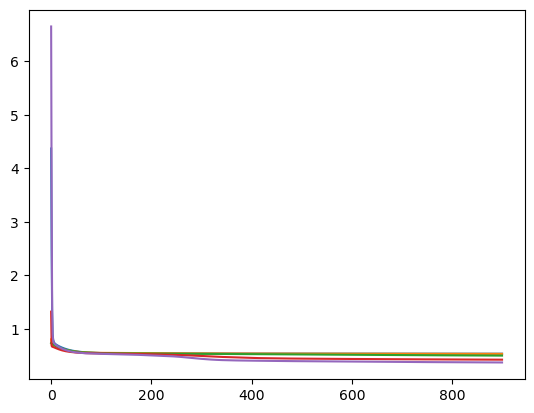

In [21]:
#task_test_acc #72.35: k1 # 83.48 k8
for idx in range(len(task_loss)):
    plt.plot(task_loss[idx]);

## Parallel with Threadpool

In [10]:
tasks

[DetectionTask_versatile(pm=1, pe=0.00039493763738907006, pn=0.3333333333333333, pc=0.45, pi=0.01, trans_prob=None, time_dep=1, k=8, random_seed=None, do_return=True)]

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def train_network(instance_id, task, task_label, nb_trials, nb_steps, repeats, nb_inputs, nb_hidden, nb_outputs, learning_rate, nb_epochs, batch_size):
    task_loss = []
    task_loss_std = []
    task_test_acc = []
    
    print(f"Instance {instance_id} training on task {task_label}")
    
    # Generate data
    full_trials_train = task.generate_trials(nb_trials, nb_steps + instance_id)
    full_trials_test = task.generate_trials(nb_trials, nb_steps + instance_id)
    
    # Generate labels
    y_train, A_train, V_train = torch.tensor(full_trials_train.M + 1).cuda(), full_trials_train.A, full_trials_train.V
    y_test, A_test, V_test = torch.tensor(full_trials_test.M + 1).cuda(), full_trials_test.A, full_trials_test.V
    
    repeat_loss = []
    for c in range(repeats):
        
        # Create a model instance
        rnn_layer = nn.RNN(input_size=nb_inputs, hidden_size=nb_hidden, nonlinearity='relu', batch_first=False).cuda()
        linear_layer = nn.Linear(nb_hidden, nb_outputs).cuda()
        
        def model(input_data):
            input_data = input_data.cuda()
            batchsize = input_data.shape[1]
            h0 = torch.zeros((1, batchsize, nb_hidden), dtype=torch.float32).cuda()
            out, h1 = rnn_layer(input_data, h0)
            lin_out = linear_layer(out)
            sum_out = lin_out.sum(axis=0).cuda()
            return sum_out
        
        optimizer = optim.Adam(list(rnn_layer.parameters()) + list(linear_layer.parameters()), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()
        
        epoch_loss = train_rnn(
            model,
            A_train,
            V_train,
            y_train,
            batch_size,
            optimizer=optimizer,
            criterion=criterion,
            nb_epochs=nb_epochs,
            lr=learning_rate)
        
        repeat_loss.append(epoch_loss)
    
    repeat_loss_mean = np.mean(repeat_loss, axis=0)
    repeat_loss_std = np.std(repeat_loss, axis=0)
    task_loss.append(repeat_loss_mean)
    task_loss_std.append(repeat_loss_std)
    
    with torch.no_grad():
        input_layer = build_input_layer(A_test, V_test)
        y_pred = model(input_layer).cpu().numpy()
        y_pred_argmax = np.argmax(y_pred, axis=1)
        test_acc = (np.mean(y_pred_argmax == y_test.cpu().numpy())) * 100
        task_test_acc.append(test_acc)
    
    return task_loss, task_loss_std, task_test_acc

if __name__ == '__main__':
    num_instances = 8

    with ThreadPoolExecutor(max_workers=num_instances) as executor:
        futures = [executor.submit(train_network, i, tasks[i], task_labels[i], nb_trials, nb_steps, repeats, nb_inputs, nb_hidden, nb_outputs, learning_rate, nb_epochs, batch_size) for i in range(num_instances)]
    
    results = [future.result() for future in futures]
    
    task_loss_all, task_loss_std_all, task_test_acc_all = zip(*results)
    
    # Combine results if needed
    combined_task_loss = np.vstack(task_loss_all)
    combined_task_loss_std = np.vstack(task_loss_std_all)
    combined_task_test_acc = np.hstack(task_test_acc_all)

    print("Training complete.")


### Parallel run

In [ ]:
import torch.multiprocessing as mp
mp.set_start_method('spawn')

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from tqdm import tqdm


def train_network(instance_id, task, task_label, nb_trials, nb_steps, repeats, nb_inputs, nb_hidden, nb_outputs, learning_rate, nb_epochs, batch_size):
    import torch
    import torch.nn as nn
    import torch.optim as optim
    import numpy as np
    print('imported')
    # Ensure CUDA is initialized within the subprocess
    if torch.cuda.is_available():
        torch.cuda.init()
    print('cuda init')
    task_loss = []
    task_loss_std = []
    task_test_acc = []
    
    print(f"Instance {instance_id} training on task {task_label}")
    
    # Generate data
    full_trials_train = task.generate_trials(nb_trials, nb_steps + instance_id)
    full_trials_test = task.generate_trials(nb_trials, nb_steps + instance_id)
    
    # Generate labels
    y_train, A_train, V_train = torch.tensor(full_trials_train.M + 1).cuda(), full_trials_train.A, full_trials_train.V
    y_test, A_test, V_test = torch.tensor(full_trials_test.M + 1).cuda(), full_trials_test.A, full_trials_test.V
    
    repeat_loss = []
    for c in range(repeats):
        
        # Create a model instance
        rnn_layer = nn.RNN(input_size=nb_inputs, hidden_size=nb_hidden, nonlinearity='relu', batch_first=False).cuda()
        linear_layer = nn.Linear(nb_hidden, nb_outputs).cuda()
        
        def model(input_data):
            input_data = input_data.cuda()
            batchsize = input_data.shape[1]
            h0 = torch.zeros((1, batchsize, nb_hidden), dtype=torch.float32).cuda()
            out, h1 = rnn_layer(input_data, h0)
            lin_out = linear_layer(out)
            sum_out = lin_out.sum(axis=0).cuda()
            return sum_out
        
        optimizer = optim.Adam(list(rnn_layer.parameters()) + list(linear_layer.parameters()), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()
        
        epoch_loss = train_rnn(
            model,
            A_train,
            V_train,
            y_train,
            batch_size,
            optimizer=optimizer,
            criterion=criterion,
            nb_epochs=nb_epochs,
            lr=learning_rate)
        
        repeat_loss.append(epoch_loss)
    
    repeat_loss_mean = np.mean(repeat_loss, axis=0)
    repeat_loss_std = np.std(repeat_loss, axis=0)
    task_loss.append(repeat_loss_mean)
    task_loss_std.append(repeat_loss_std)
    
    with torch.no_grad():
        input_layer = build_input_layer(A_test, V_test)
        y_pred = model(input_layer).cpu().numpy()
        y_pred_argmax = np.argmax(y_pred, axis=1)
        test_acc = (np.mean(y_pred_argmax == y_test.cpu().numpy())) * 100
        task_test_acc.append(test_acc)
    
    return task_loss, task_loss_std, task_test_acc

if __name__ == '__main__':
    num_instances = 1
    
    with mp.Pool(processes=num_instances) as pool:
        results = pool.starmap(train_network, [(i, tasks[i], task_labels[i], nb_trials, nb_steps, repeats, nb_inputs, nb_hidden, nb_outputs, learning_rate, nb_epochs, batch_size) for i in range(num_instances)])
    
    task_loss_all, task_loss_std_all, task_test_acc_all = zip(*results)
    
    # Combine results if needed
    combined_task_loss = np.vstack(task_loss_all)
    combined_task_loss_std = np.vstack(task_loss_std_all)
    combined_task_test_acc = np.hstack(task_test_acc_all)

    print("Training complete.")


In [ ]:
tasks

In [ ]:
task_labels[0]

In [ ]:
plt.plot(task_test_acc)

In [ ]:
np.save('test_acc_trial1.npy', task_test_acc)

In [ ]:
import json

# Assuming rnn_params is defined as shown previously
rnn_params = {
    'nb_inputs': nb_inputs,
    'nb_hidden': nb_hidden,
    'nb_layers': nb_layers,
    'nb_outputs': nb_outputs,
    'nb_epochs': nb_epochs,
    'repeats': repeats,
    'batch_size': batch_size,
    'positive_weights': positive_weights,
    'nb_trials': nb_trials,
    'nb_steps': nb_steps,
    'learning_rate': learning_rate
}

# Specify the filename
filename = 'rnn_params_trial1.json'

# Write the dictionary to a JSON file
with open(filename, 'w') as file:
    json.dump(rnn_params, file, indent=4)


# Hyperparameter tuning

### Train and evaluate function

In [11]:
# Train networks
def train_and_evaluate_model(t, task, nb_hidden, nb_epochs, repeats, batch_size, learning_rate, nb_trials, objective_trial):
    task_loss = []
    task_loss_std = []
    task_test_acc = []

    #nb_trials = batch_size * nb_trials_mult
    
    # Generate data
    print(t,task_labels[t])
    
    full_trials_train = task.generate_trials(nb_trials, nb_steps)
    full_trials_test = task.generate_trials(nb_trials, nb_steps)
    
    print('Train-Test generated') # logging
    
    # Generate labels
    y_train, A_train, V_train = torch.tensor(full_trials_train.M + 1), full_trials_train.A, full_trials_train.V
    y_test, A_test, V_test = torch.tensor(full_trials_test.M + 1), full_trials_test.A, full_trials_test.V

    repeat_loss = []
    for c in range(repeats):
        
        # Create a model instance
        rnn_layer = nn.RNN(input_size=nb_inputs, hidden_size=nb_hidden, nonlinearity='relu', batch_first=False)
        
        linear_layer = nn.Linear(nb_hidden, nb_outputs)
               
        def model(input_data):
            input_data = input_data.cuda()
            batchsize = input_data.shape[1]
            h0 = torch.zeros((1, batchsize, nb_hidden), dtype=torch.float32).cuda()
            out, h1 = rnn_layer(input_data, h0)
            lin_out = linear_layer(out)
            sum_out = lin_out.sum(axis=0).cuda()
            return sum_out
                                  
        
        optimizer = torch.optim.Adam(list(rnn_layer.parameters()) + list(linear_layer.parameters()), lr=learning_rate)
        criterion = nn.CrossEntropyLoss()  # CrossEntropyLoss in PyTorch internally applies a LogSoftmax layer to its inputs before computing the negative log likelihood loss. 
    
        epoch_loss = train_rnn( # loss from all epochs
                model,
            A_train,
            V_train,
            y_train,
            batch_size,
            optimizer=optimizer,
            criterion=criterion,
            nb_epochs=nb_epochs,
            lr=learning_rate,
            )
        # Report intermediate objective value
        intermediate_value = np.mean(epoch_loss)
        objective_trial.report(intermediate_value, c)

        # Handle pruning based on the intermediate value.
        if objective_trial.should_prune():
            raise optuna.exceptions.TrialPruned()
            
        repeat_loss.append(epoch_loss)
    repeat_loss_mean = np.mean(repeat_loss, axis = 0)   
    repeat_loss_std = np.std(repeat_loss, axis = 0)
    task_loss.append(repeat_loss_mean)
    task_loss_std.append(repeat_loss_std)
    
    with torch.no_grad():
        input_layer = build_input_layer(A_test, V_test)
        y_pred = model(input_layer).cpu().numpy()
        y_pred_argmax = np.argmax(y_pred, axis=1)
        test_acc = (np.mean(y_pred_argmax == y_test.cpu().numpy()))*100
    del full_trials_train, full_trials_test, y_train, A_train, V_train, y_test, A_test, V_test, input_layer, y_pred, y_pred_argmax
    torch.cuda.empty_cache()
    return test_acc, task_loss, task_loss_std



### Objective function

In [13]:
def objective(trial, task, task_index):
    # Define hyperparameters
    nb_hidden = trial.suggest_int('nb_hidden', 50, 200)
    #learning_rate = trial.suggest_loguniform('learning_rate', 1e-5, 1e-4)
    #batch_size = trial.suggest_categorical('batch_size', [16, 32, 64, 128])
    #nb_trials_mult = trial.suggest_int('nb_trials_mult', 100, 600)
    #nb_epochs = trial.suggest_int('nb_epochs', 20, 100)

    # Train and evaluate the model
    batch_size = 32
    learning_rate = 1e-6
    nb_trials = batch_size * 500 
    nb_epochs = 900

    print(task)
    accuracy, training_loss, task_loss_std = train_and_evaluate_model(task_index, task, nb_hidden, nb_epochs, repeats, batch_size, learning_rate, nb_trials, trial) # trial is passed as objective_trial

    return accuracy  # Focus on optimizing accuracy


### Optimiser setup

In [39]:
tasks

[DetectionTask_versatile(pm=1, pe=0.00039493763738907006, pn=0.3333333333333333, pc=0.45, pi=0.01, trans_prob=None, time_dep=1, k=8, random_seed=None, do_return=True)]

In [22]:
np.arange(50, 225,25).tolist()

[50, 75, 100, 125, 150, 175, 200]

In [ ]:
#%%timeit
# Setup the pruner to cut trials below the 30th percentile 
"""
PercentilePruner:
Pruner to keep the specified percentile of the trials.
Prune if the best intermediate value is in the bottom percentile among trials at the same step.
"""
pruner = optuna.pruners.PercentilePruner(percentile=60, n_startup_trials=10)
#sampler = optuna.samplers.TPESampler()
#study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)

#searchspace_list = np.arange(50, 225,25).tolist()
searchspace_list = [50, 100, 250]# np.arange(50, 150, 50).tolist()

#searchspace_list = np.arange(2, 5,1).tolist()
search_space = {"nb_hidden": searchspace_list}
sampler = optuna.samplers.GridSampler(search_space)
study = optuna.create_study(direction='maximize', sampler=sampler, pruner=pruner)

#study.optimize(objective)

#study.optimize(objective, n_trials=1)
obj_task=tasks[0]
obj_task_index=0
study.optimize(lambda trial: objective(trial, obj_task, obj_task_index), n_trials=100)
print("Best trial:", study.best_trial.params)

[I 2024-06-12 01:31:39,743] A new study created in memory with name: no-name-b05fffda-5e81-4c67-9459-0d8e3d3a46dd
/home/jupyter-swathi/.conda/envs/cuda-env/lib/python3.12/site-packages/optuna/samplers/_grid.py:198: UserWarning: The value `250` is out of range of the parameter `nb_hidden`. The value will be used but the actual distribution is: `IntDistribution(high=200, log=False, low=50, step=1)`.
  warnings.warn(


DetectionTask_versatile(pm=1, pe=0.00039493763738907006, pn=0.3333333333333333, pc=0.45, pi=0.01, trans_prob=None, time_dep=1, k=8, random_seed=None, do_return=True)
0 Sparse Det_8
Train-Test generated
Epoch [10/900], Loss: 0.6398
Epoch [20/900], Loss: 0.5169
Epoch [30/900], Loss: 0.5697
Epoch [40/900], Loss: 0.4425
Epoch [50/900], Loss: 0.5363
Epoch [60/900], Loss: 0.5182
Epoch [70/900], Loss: 0.4988
Epoch [80/900], Loss: 0.3902
Epoch [90/900], Loss: 0.4650
Epoch [100/900], Loss: 0.5549
Epoch [110/900], Loss: 0.4824
Epoch [120/900], Loss: 0.5830
Epoch [130/900], Loss: 0.4576
Epoch [140/900], Loss: 0.5793
Epoch [150/900], Loss: 0.4856
Epoch [160/900], Loss: 0.4861
Epoch [170/900], Loss: 0.6094
Epoch [180/900], Loss: 0.6687
Epoch [190/900], Loss: 0.3349
Epoch [200/900], Loss: 0.5610
Epoch [210/900], Loss: 0.6765
Epoch [220/900], Loss: 0.5007
Epoch [230/900], Loss: 0.3888
Epoch [240/900], Loss: 0.4874
Epoch [250/900], Loss: 0.3750
Epoch [260/900], Loss: 0.4814
Epoch [270/900], Loss: 0.41

[I 2024-06-12 02:11:54,476] Trial 0 finished with value: 84.53125 and parameters: {'nb_hidden': 250}. Best is trial 0 with value: 84.53125.


DetectionTask_versatile(pm=1, pe=0.00039493763738907006, pn=0.3333333333333333, pc=0.45, pi=0.01, trans_prob=None, time_dep=1, k=8, random_seed=None, do_return=True)
0 Sparse Det_8
Train-Test generated
Epoch [10/900], Loss: 18.1576
Epoch [20/900], Loss: 7.3652
Epoch [30/900], Loss: 0.9538
Epoch [40/900], Loss: 0.7785
Epoch [50/900], Loss: 0.7868
Epoch [60/900], Loss: 0.7537
Epoch [70/900], Loss: 0.6667
Epoch [80/900], Loss: 0.6053
Epoch [90/900], Loss: 0.5933
Epoch [100/900], Loss: 0.6217
Epoch [110/900], Loss: 0.6281
Epoch [120/900], Loss: 0.6038
Epoch [130/900], Loss: 0.5492
Epoch [140/900], Loss: 0.5950
Epoch [150/900], Loss: 0.5505
Epoch [160/900], Loss: 0.5216
Epoch [170/900], Loss: 0.5788
Epoch [180/900], Loss: 0.5677
Epoch [190/900], Loss: 0.5421
Epoch [200/900], Loss: 0.5367
Epoch [210/900], Loss: 0.4956
Epoch [220/900], Loss: 0.6159
Epoch [230/900], Loss: 0.5724
Epoch [240/900], Loss: 0.5253
Epoch [250/900], Loss: 0.4845
Epoch [260/900], Loss: 0.4490
Epoch [270/900], Loss: 0.4

[I 2024-06-12 02:48:41,544] Trial 1 finished with value: 77.05 and parameters: {'nb_hidden': 50}. Best is trial 0 with value: 84.53125.


DetectionTask_versatile(pm=1, pe=0.00039493763738907006, pn=0.3333333333333333, pc=0.45, pi=0.01, trans_prob=None, time_dep=1, k=8, random_seed=None, do_return=True)
0 Sparse Det_8
Train-Test generated
Epoch [10/900], Loss: 0.8907
Epoch [20/900], Loss: 0.7162
Epoch [30/900], Loss: 0.6969
Epoch [40/900], Loss: 0.6202
Epoch [50/900], Loss: 0.5849
Epoch [60/900], Loss: 0.5516
Epoch [70/900], Loss: 0.6319
Epoch [80/900], Loss: 0.5531
Epoch [90/900], Loss: 0.5199
Epoch [100/900], Loss: 0.4889
Epoch [110/900], Loss: 0.5093
Epoch [120/900], Loss: 0.4800
Epoch [130/900], Loss: 0.5737
Epoch [140/900], Loss: 0.5291
Epoch [150/900], Loss: 0.4809
Epoch [160/900], Loss: 0.5071
Epoch [170/900], Loss: 0.4937
Epoch [180/900], Loss: 0.5337
Epoch [190/900], Loss: 0.6004
Epoch [200/900], Loss: 0.4857
Epoch [210/900], Loss: 0.6812
Epoch [220/900], Loss: 0.4693
Epoch [230/900], Loss: 0.5468
Epoch [240/900], Loss: 0.4875
Epoch [250/900], Loss: 0.4471
Epoch [260/900], Loss: 0.4808
Epoch [270/900], Loss: 0.47

In [18]:
results

[{'hyperparameters': {'nb_hidden': 150}, 'objective_value': 79.8875},
 {'hyperparameters': {'nb_hidden': 100}, 'objective_value': 83.29375},
 {'hyperparameters': {'nb_hidden': 200}, 'objective_value': 83.85000000000001}]

In [15]:
# Save the results
results = []
for trial in study.trials:
    result = {
        'hyperparameters': trial.params,
        'objective_value': trial.value
    }
    results.append(result)


In [16]:
results_ep900 = results
results_ep900 # 250: 84.53, 50: 77.05

[{'hyperparameters': {'nb_hidden': 150}, 'objective_value': 79.8875},
 {'hyperparameters': {'nb_hidden': 100}, 'objective_value': 83.29375},
 {'hyperparameters': {'nb_hidden': 200}, 'objective_value': 83.85000000000001}]

In [19]:
results_ep900 = [{'hyperparameters': {'nb_hidden': 50}, 'objective_value': 77.05},
    {'hyperparameters': {'nb_hidden': 150}, 'objective_value': 79.8875},
 {'hyperparameters': {'nb_hidden': 100}, 'objective_value': 83.29375},
 {'hyperparameters': {'nb_hidden': 200}, 'objective_value': 83.85000000000001},
{'hyperparameters': {'nb_hidden': 250}, 'objective_value': 84.53}]

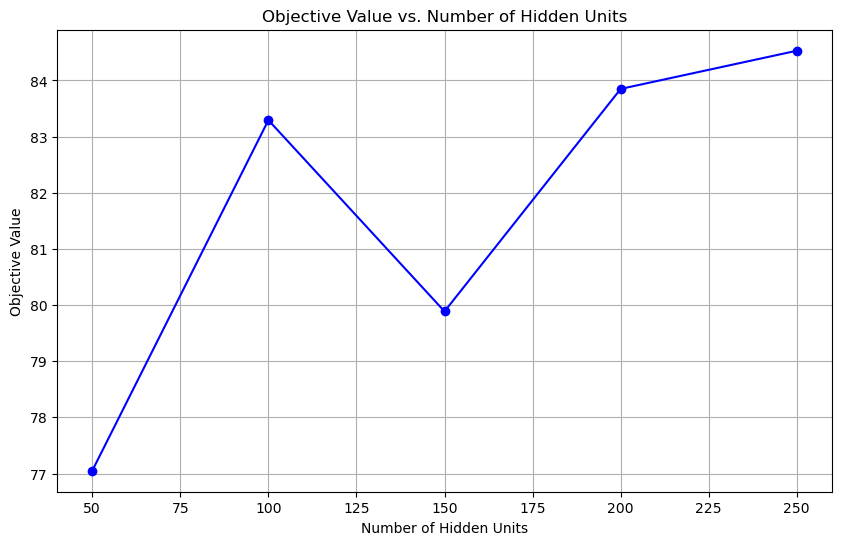

In [20]:
import matplotlib.pyplot as plt

# Sort data by nb_hidden in ascending order
sorted_data = sorted(results_ep900, key=lambda x: x['hyperparameters']['nb_hidden'])

# Extract sorted data for plotting
nb_hidden = [entry['hyperparameters']['nb_hidden'] for entry in sorted_data]
objective_values = [entry['objective_value'] for entry in sorted_data]

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(nb_hidden, objective_values, marker='o', linestyle='-', color='b')
plt.xlabel('Number of Hidden Units')
plt.ylabel('Objective Value')
plt.title('Objective Value vs. Number of Hidden Units')
plt.grid(True)
plt.show()

In [42]:
results
# Save results to a JSON file
with open('optuna_results.json', 'w') as f:
    json.dump(results, f, indent=4)

print("Results saved to optuna_results.json")

NameError: name 'json' is not defined

# Plots for performance

In [ ]:
task_labels

In [14]:
task_test_acc#:[92.390625, 90.60000000000001, 85.85625, 84.22500000000001, 82.15625, 78.48125, 75.68125, 73.54375]



[72.52678571428571,
 73.46428571428572,
 74.05357142857143,
 76.30357142857143,
 78.47321428571429]

### Training loss

In [ ]:
for t, loss in enumerate(task_loss[:]):
    x = range(1, nb_epochs+1, 1)
    plt.plot(x, loss, marker='|', label=task_labels[t]);
    # Filling between the +std and -std with a lighter color
    plt.fill_between(x, loss - task_loss_std[t], loss + task_loss_std[t], alpha=0.2);
plt.xlabel('epochs')
plt.legend(frameon=0)
plt.grid()
plt.ylabel('Training accuracy')
# Setting the x-axis ticks
plt.xticks(range(1, nb_epochs+1, int(nb_epochs/5)));  # Sets ticks from 1 to 10, spaced 1 apart
#plt.ylim(top=8, bottom=0.4)

### RNN Vs Algorithm

In [ ]:
#RNN full run

#task_test_acc



RNN_acc = [94.12083333333334,
 94.35625,
 90.64791666666666,
 86.11041666666667,
 82.07083333333334,
 79.26458333333333,
 76.00625,
 73.85625]

In [ ]:
df = pd.read_csv('./data/idea_data/ideal_data_sparse.csv')
# Set the 'Unnamed: 0' column as the index and rename it to 'task'
df.set_index('Unnamed: 0', inplace=True)
df.index.name = 'task'
df


In [ ]:
df.loc['Classical'] = [0.947, 0.947, 0.947, 0.947, 0.9455]
df

In [14]:
df['RNN'] = [xx/100 for xx in task_test_acc]
df

,LF,NLF_1,NLF_2,NLF_3,RNN
task,,,,,
Sparse Det_1,0.688,0.699,0.699,0.696,0.698458
Sparse Det_2,0.689,0.700,0.711,0.709,0.705375
Sparse Det_4,0.686,0.697,0.720,0.731,0.733542
Sparse Det_6,0.686,0.698,0.724,0.741,0.757458
Sparse Det_8,0.683,0.693,0.723,0.744,0.782125


In [ ]:
task_test_acc

In [ ]:
import pandas as pd

# Create the DataFrame
data = {
    'LF': [0.868, 0.842, 0.819, 0.800, 0.781, 0.765, 0.746, 0.728, 0.947],
    'NLF': [0.941, 0.906, 0.872, 0.843, 0.815, 0.788, 0.761, 0.736, 0.947],
    'NLF_2': [0.940, 0.946, 0.905, 0.863, 0.826, 0.794, 0.764, 0.739, 0.947],
    'NLF_3': [0.939, 0.944, 0.906, 0.862, 0.824, 0.791, 0.762, 0.737, 0.947]
}
index = [
    'Sparse Det_1', 'Sparse Det_2', 'Sparse Det_3', 'Sparse Det_4', 'Sparse Det_5',
    'Sparse Det_6', 'Sparse Det_7', 'Sparse Det_8', 'Classical'
]

df = pd.DataFrame(data, index=index)

In [ ]:
# Extract the last row and drop it from the DataFrame
last_row = df.iloc[-1:]
df = df.drop(df.index[-1])

# Concatenate the last row at the top of the DataFrame
df = pd.concat([last_row, df])
#df['RNN'] = [xx/100 for xx in task_test_acc]
# Print the updated DataFrame
pd.DataFrame(df)

In [ ]:
RNN_incor = [94.12083333333334,
 94.35625,
 90.64791666666666,
 86.11041666666667]
plt.figure(figsize=(4,3))
plt.plot(['Classical', 'k=1', 'k=2', 'k=3'], task_test_acc, marker='X', label='RNN')
plt.plot(['Classical', 'k=1', 'k=2', 'k=3'], RNN_incor, marker='X', label='RNN w/o trial replacement')

plt.ylabel('Accuracy')
plt.legend(frameon=0)

Index(['Sparse Det_1', 'Sparse Det_2', 'Sparse Det_4', 'Sparse Det_6',
       'Sparse Det_8'],
      dtype='object', name='task')

(0.65, 0.85)

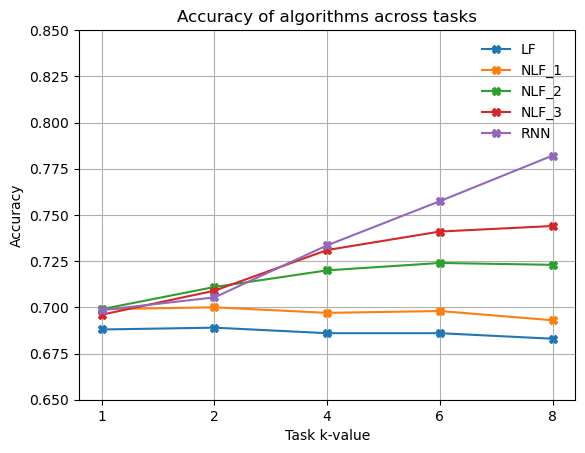

In [40]:
plt.plot(df, marker='X',label=df.columns)
plt.grid()
plt.legend(frameon=0)
plt.title('Accuracy of algorithms across tasks')
plt.ylabel('Accuracy')
plt.xlabel('Task k-value')
plt.xticks(ticks=df.index, labels=[1,2,4,6,8]);
plt.ylim(bottom=0.65, top=0.85)

In [ ]:
plt.figure(figsize=(5.5,4))
plt.plot(df.iloc[:]*100, ls='-', marker='x', label=df.columns)
plt.xticks(fontsize=13)
plt.yticks(fontsize=13)
plt.ylim(bottom=70)
plt.ylabel('Accuracy', fontsize=17)
#plt.grid()
# Removing top and right borders
ax = plt.gca()  # Get current axis
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.title('Accuracy of algorithms across tasks')
plt.vlines(1, 0.7, 0.96, ls='--', color='salmon', linewidth=3)
plt.vlines(2, 0.7, 0.96, ls='--', color='grey', linewidth=3)
plt.legend(frameon=0)
plt.xticks(ticks=[0, 1, 2, 3, 4, 5, 6, 7, 8], labels=['Classical', 1, 2, 3, 4, 5, 6, 7, 8]);
plt.xlabel('Time-steps per on-time (k)', fontsize=17)


In [ ]:
plt.plot(df.iloc[:], ls='-', marker='x', label=df.columns)
plt.xticks(rotation=45)
plt.ylim(bottom=0.7)
plt.ylabel('Accuracy')
#plt.grid()
plt.title('Accuracy of algorithms across tasks')
plt.vlines(1, 0.7, 0.96, ls='--', color='salmon', linewidth=3)
plt.vlines(2, 0.7, 0.96, ls='--', color='grey', linewidth=3)
plt.legend()

In [ ]:
#plt.plot(df.iloc[:]['LF'], ls='--', marker='x', label='LF')
plt.plot(df.iloc[:]['RNN'], ls='--', marker='x', label='RNN')
plt.plot(df.iloc[:]['NLF_2'], ls='--', marker='x', label='NLF_2')
plt.plot(df.iloc[:]['NLF_3'], ls='--', marker='x', label='NLF_3')
plt.xticks(rotation=45);
#plt.ylim(bottom=0.8)
plt.legend()

In [ ]:
plt.figure(figsize=(5,4))
x = [1,2,3,4,5,6, 7, 8]
col = [ 'C9-',  'C6-',  'C4-']
for t, task in enumerate(['ATF', 'FTA', 'FTAt']):
    ax = plt.stem([xx+(t*0.1) for xx in x], task_test_acc-exclude_de2[task], label=task, linefmt= col[t])

plt.xticks(x, [ll for ll in task_labels])
plt.legend(frameon=0)
plt.ylabel('RNN - Alg')
plt.xticks(rotation=45);



In [ ]:
def savedata(input, name, type='npy'):
    np.save(f"{name}.{type}", input)

def loaddata(name, type='npy'):
    data = np.load(f"{name}.{type}")
    return data

#### set aside

In [ ]:
# Plot reaction times
rt_list_new = [rt_list[0], rt_list[2], rt_list[4], rt_list[6]]
fig, ax = plt.subplots(
    1, len(tasks), figsize=(10, 5), sharex=True, sharey=True, constrained_layout=True
)

for network in range(len(rt_list_new)):
    
    plt.sca(ax[task_list[network]])
    plt.plot(
        np.mean(100 * rt_list_new[network], axis=1),
        color=colors_ma[ma_list[network]],
        alpha=alpha_ma[ma_list[network]],
    )
    

plt.sca(ax[0])
plt.xlabel("Time")
plt.ylim([30, 200])
plt.ylabel("Accuracy")
ii = 0
for t, task in enumerate(ideal_data.keys()):
    print(ii)
    plt.sca(ax[t])
    plt.plot(np.array(ideal_data[task]) * 100, color="xkcd:gray")
    plt.title(task_labels[t])
    ii+=1

#plt.savefig("AF_comp_1.svg")